## Local authority dataset validation


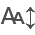

In [1]:
from policyengine_uk import Microsimulation
import pandas as pd
import h5py
import numpy as np
import sys
from itables import init_notebook_mode
import itables.options as opt
from pathlib import Path
from policyengine_uk_data.storage import STORAGE_FOLDER

opt.maxBytes = "1MB"
init_notebook_mode(all_interactive=True)

REPO = Path(".").resolve().parent

with h5py.File(STORAGE_FOLDER / "local_authority_weights.h5", "r") as f:
    weights = f["2025"][:]

baseline = Microsimulation()
household_weights = baseline.calculate("household_weight", 2025).values

from policyengine_uk_data.datasets.frs.local_areas.local_authorities.loss import create_local_authority_target_matrix, create_national_target_matrix

local_authority_target_matrix, local_authority_actuals = create_local_authority_target_matrix("enhanced_frs_2022_23", 2025, None)
national_target_matrix, national_actuals = create_national_target_matrix("enhanced_frs_2022_23", 2025, None)
constituencies_2024 = pd.read_csv(STORAGE_FOLDER / "local_authorities_2021.csv")

local_authority_wide = weights @ local_authority_target_matrix
local_authority_wide.index = constituencies_2024.code.values
local_authority_wide["name"] = constituencies_2024.name.values

local_authority_results = pd.melt(local_authority_wide.reset_index(), id_vars=["index", "name"], var_name="variable", value_name="value")

local_authority_actuals.index = constituencies_2024.code.values
local_authority_actuals["name"] = constituencies_2024.name.values
local_authority_actuals_long = pd.melt(local_authority_actuals.reset_index(), id_vars=["index", "name"], var_name="variable", value_name="value")

local_authority_target_validation = pd.merge(local_authority_results, local_authority_actuals_long, on=["index", "variable"], suffixes=("_target", "_actual"))
local_authority_target_validation.drop("name_actual", axis=1, inplace=True)
local_authority_target_validation.columns = ["index", "name", "metric", "estimate", "target"]

local_authority_target_validation["error"] = local_authority_target_validation["estimate"] - local_authority_target_validation["target"]
local_authority_target_validation["abs_error"] = local_authority_target_validation["error"].abs()
local_authority_target_validation["rel_abs_error"] = local_authority_target_validation["abs_error"] / local_authority_target_validation["target"]

### Calibration check
Looking at the sorted validation results by relative absolute error shows how well our calibrated weights perform against the actual target statistics across UK parliamentary constituencies under the new 2024 boundaries. The table reveals the accuracy of our estimates, from the closest matches to the largest discrepancies, where a lower relative error indicates better calibration performance.

In [2]:
local_authority_target_validation.sort_values("rel_abs_error")

index                name  \
7682  E07000102        Three Rivers   
3227  W06000011             Swansea   
5640  E08000014              Sefton   
6179  E06000063          Cumberland   
7022  E07000193  East Staffordshire   
...         ...                 ...   
4998  S12000023      Orkney Islands   
4943  E09000001      City of London   
769   E06000053     Isles of Scilly   
1129  E06000053     Isles of Scilly   
1849  E06000053     Isles of Scilly   

                                         metric      estimate        target  \
7682  hmrc/employment_income/amount/50000_70000  6.835184e+08  6.835077e+08   
3227                                  age/60_70  2.865268e+04  2.865445e+04   
5640  hmrc/employment_income/amount/20000_30000  3.690511e+08  3.690074e+08   
6179  hmrc/employment_income/amount/30000_40000  7.644177e+08  7.643270e+08   
7022  hmrc/employment_income/amount/40000_50000  3.140948e+08  3.140508e+08   
...                                         ...           ...           ...   
4998  hmrc/employment_income/amount/15000_20000  4.427085e+06  1.308275e+06   
4943  hmrc/employment_income/amount/15000_20000  4.447282e+06  1.308275e+06   
769                                    age/0_10  6.712070e+02  1.954337e+02   
1129                                  age/10_20  7.329886e+02  2.066304e+02   
1849                                  age/30_40  8.760654e+02  2.300417e+02   

             error     abs_error  rel_abs_error  
7682  1.071678e+04  1.071678e+04       0.000016  
3227 -1.769448e+00  1.769448e+00       0.000062  
5640  4.374969e+04  4.374969e+04       0.000119  
6179  9.073156e+04  9.073156e+04       0.000119  
7022  4.394198e+04  4.394198e+04       0.000140  
...            ...           ...            ...  
4998  3.118810e+06  3.118810e+06       2.383910  
4943  3.139007e+06  3.139007e+06       2.399348  
769   4.757734e+02  4.757734e+02       2.434449  
1129  5.263582e+02  5.263582e+02       2.547342  
1849  6.460237e+02  6.460237e+02       2.808289  

[7920 rows x 8 columns]

In [3]:
national_performance = household_weights @ national_target_matrix
national_target_validation = pd.DataFrame({"metric": national_performance.index, "estimate": national_performance.values})
national_target_validation["target"] = national_actuals.values

national_target_validation["error"] = national_target_validation["estimate"] - national_target_validation["target"]
national_target_validation["abs_error"] = national_target_validation["error"].abs()
national_target_validation["rel_abs_error"] = national_target_validation["abs_error"] / national_target_validation["target"]

The table below shows the relative absolute error for each calibration target at the **national level**, sorted from the closest matches to the largest discrepancies.

In [4]:
national_target_validation.sort_values("rel_abs_error")

metric      estimate  \
32                                     obr/tax_credits  8.095053e+07   
68                         ons/west_midlands_age_10_19  7.429357e+05   
123                             ons/scotland_age_20_29  7.089335e+05   
324  hmrc/self_employment_income_count_income_band_...  3.716194e+06   
301  hmrc/property_income_income_band_53_500_000.0_...  5.764153e+08   
..                                                 ...           ...   
313  hmrc/private_pension_income_income_band_54_1_0...  1.923202e+08   
297  hmrc/state_pension_income_band_53_500_000.0_to...  4.931677e+07   
38                           obr/winter_fuel_allowance  4.894976e+08   
18                     obr/winter_fuel_allowance_count  1.991194e+06   
25                                  obr/domestic_rates  0.000000e+00   

           target         error     abs_error  rel_abs_error  
32  -1.000000e+08  1.809505e+08  1.809505e+08      -1.809505  
68   7.430000e+05 -6.430588e+01  6.430588e+01       0.000087  
123  7.090000e+05 -6.650023e+01  6.650023e+01       0.000094  
324  3.716570e+06 -3.759030e+02  3.759030e+02       0.000101  
301  5.761748e+08  2.405176e+05  2.405176e+05       0.000417  
..            ...           ...           ...            ...  
313  3.732529e+08 -1.809327e+08  1.809327e+08       0.484746  
297  1.058525e+08 -5.653571e+07  5.653571e+07       0.534099  
38   1.900000e+09 -1.410502e+09  1.410502e+09       0.742370  
18   1.100000e+07 -9.008806e+06  9.008806e+06       0.818982  
25   4.000000e+08 -4.000000e+08  4.000000e+08       1.000000  

[335 rows x 6 columns]